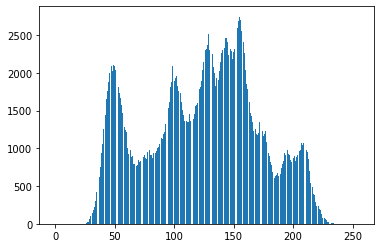


  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3  0  0  0  4  4  4  4  4  4  4  4  4  0  5  5  5  5  5  5  5  5  5  0  6  0  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  0  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  0  9  9  0 10 10 10 10  0  0 11  0 12 12  0  0 13 13 13 13  0 14  0  0 15  0  0  0 16  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 18 18 18 18 18 18 18

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0 31 31 31  4  4  4  4  4  0 32  0  5  5  5  5  5  5  0  5  0  7  7  7  7  7  0  0  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  0  7  7  7  7  7  7  7  0  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  0  7  7  7  0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  0 10 10 10 10 10 10 10 10 10 10 10  0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  0 10  0 10  0  0 10 10 10  0  0 10 10 10 10  0  0  0 33  0  0 11 11 11  0 34 34 34 13  0 13  0  0 35 35 15  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 18 18 18 18 18 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0136  0  0121121  0  0  0101101101101101  0 89 89 89 89 89  0 89 89 89 89 89 89 89 89 89 89  0 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89  0 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89  0 89  0137137 89 89 89 89 89 89 89 89  0 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89  0138138  0 89 89  0125125125125 89  0  0  0  0139  0107107107107107  0 15 15 15 15 15 15 15  0 68 68 68 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 18 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0245245  0  0208208208  0  0  0246  0234  0  0208208  0247  0  0  0208  0248248208208208208208208208208208208208208208208208  0  0249249208  0208208208208208208208  0208  0208  0208208208208208208208208208208208208208208208208  0  0  0  0  0  0  0250  0  0  0  0  0  0  0  0  0220220  0208208  0  0  0  0251  0  0  0239239  0  0  0252  0  0253  0  0254254  0  0  0  0208208208208208208208208208208208208208208208208  0  0  0255  0  0256256  0257  0258  0  0208  0  0  0259  0  0  0227  0260260210  0  0  0  0  0  0  0243243243  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0319  0  0  0  0  0  0  0  0320  0321  0  0300  0322  0234  0323323  0  0324  0  0  0325325325325288  0288288288288288288288288288288288288288288288288288288288288288  0  0288288288288288288  0  0288288  0288288288288288288288288288288288  0  0  0  0  0288  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0326  0  0  0327  0  0  0  0  0328  0  0  0  0  0  0  0  0288288  0288  0288288288  0288  0329  0288288288288288288288288288288288  0330330330  0  0288288288  0331  0  0288288  0332  0  0333333333333  0  0  0334  0  0  0315  0  0281  0281  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  03

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0427  0  0  0  0409  0428  0  0  0  0  0  0429  0  0  0430  0  0  0  0  0  0  0376  0376  0  0376376376  0356356  0431  0  0376376  0376  0376  0432  0  0376376  0  0376376376401401401401401401401401  0  0  0433433  0  0  0434  0  0  0435435  0  0436  0  0  0419  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0437  0  0  0  0  0401401401401401401401401401  0438438  0  0439  0401  0  0  0  0  0401401401  0  0440  0  0406  0  0  0441441  0442442442  0  0  0443  0  0  0  0  0444  0445  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0531  0532  0  0  0  0  0  0  0  0  0517517  0533533487487  0  0  0534534487487487487487487  0  0  0  0535535518518487487487487487487487487487487  0  0  0536  0  0  0537537  0487487487487487487  0  0  0538  0  0  0  0  0539  0540540540540540540540540540521521504504504504504504504504504504504504504504504504504504504504504504  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0541  0  0  0  0  0  0  0  0  0  0524  0525  0542542542487487  0487487487  0543543  0  0  0  0  0  0508  0  0544  0  0  0527  0  0  0510  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0584584584  0604  0  0  0  0  0  0  0  0  0595  0  0  0504504504504504504504  0504504504504504  0504504504504  0605  0606  0  0  0  0  0  0596  0596596596596596  0607  0  0  0  0  0  0608608608596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596596  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0596  0  0  0  0596  0596596  0  0  0567567  0609  0601  0  0  0  0  0  0  0  0610  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0650  0  0  0  0  0  0  0  0  0  0651  0  0  0652  0  0  0  0  0  0632632  0  0  0  0653653640640640  0  0654  0  0  0  0  0  0  0  0  0  0655655632632632632632632632632632  0  0  0  0  0632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0634634  0  0  0  0  0  0656  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0681  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0682682671671  0  0  0  0  0  0632  0632  0  0  0  0  0  0  0  0  0  0  0  0  0  0683  0684684632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0710  0711711704  0  0  0  0712  0  0  0  0713713  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0698  0  0  0  0  0  0707707707707707632632632  0632632  0  0714714632632632632632632  0632632632632632632  0632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0732732713713  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0733  0  0  0  0734  0  0  0  0  0735735632632632  0  0736736632632632632632632632632632632632632  0632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0713713  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0770  0  0  0771  0  0  0772  0  0773773632  0  0632632  0632632632632  0774774632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0632  0632632632632  0800800632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0827827  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0828  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0820820820  0  0829829825825825825632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0865865  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0866866632  0  0867867  0  0868868868632632632632632632632632632632632632632632632632632632632632632632  0632632632632632632632632632632632632632632632632632632  0869869869632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632632  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0890890  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0878878  0  0  0891891891878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878  0  0878878  0892892878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878  0  0  0  0  0  0  0  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0922922  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0831831831831  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0923  0  0924924924924  0  0925925925878878878878878878  0  0926926926878878  0927927878878878878878878878  0  0928928878  0929929  0  0  0  0  0  0  0930930878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878  0  0  0  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0831831831831831  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0967967967878878878878878878878878878878878878878878878878  0  0  0968968878878878878878878  0  0  0  0  0  0  0  0  0  0  0  0969969878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878  0  0  0  0  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0831831831831831831831  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  01006  0  0985985985985878  0  0  0  010071007  0  0  0  010081008878878878878878878878  0100910091009  0  0  0  0  0  0  010101010878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878878

KeyboardInterrupt: 

In [16]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import math, sys
import matplotlib.pyplot as plt
from PIL import Image

'''
savefig sould be done before show
see: https://blog.csdn.net/u010099080/article/details/52912439
'''

####### hist part ########
def img_hist(img_in):
    hist = []
    for i in range(256):
        hist.append(0)

    row, col= img_in.shape
    for i in range(0, row):
        for j in range(0, col):
            hist[img_in[i, j]] += 1

    plt.bar(range(0, 256), hist)
    plt.savefig('histogram.png')
    plt.show()
    return 0

####### binarize part ######
def img_binarize(img_in):
    return (img_in > 0x7f) * 0xff

########## IO ##############
img = cv2.imread('lena.bmp', 0)
#plt.imshow(img, cmap = 'gray')
#plt.show()

img_binarized = img_binarize(img)
#plt.imshow(img_binarized, cmap = 'gray')
plt.savefig('lena_binarized.png', cmap = 'gray')
#plt.show()

img_hist(img)

######### CC part ##########
parent_label = []
cc_img = (img_binarized == 0xff) * 1

def union_find(label):
    original_label = label
    cnt = 0
    row, col = cc_img.shape
    while label != parent_label[label] and cnt < row * col:
        label = parent_label[parent_label[label]]
        cnt += 1

    parent_label[original_label] = label # path compression to avoid TLE
    return label

def draw_rect(img, left, right, top, bottom, color):
    return 0

def draw_cent():
    return 0

def connected_components():
    # set parent label
    # plt.imshow(cc_img, cmap = 'gray')
    row, col = cc_img.shape
    for i in range(row * col):
        parent_label.append(i)

    # do connected components
    label = 2
    for i in range(row):
        for j in range(col):
            ok1 = 0
            ok2 = 0
            if cc_img[i, j] == 1:
                if j - 1 >= 0 and cc_img[i, j - 1] > 1: # left has already labeled
                    #print(i, j, 'type 1,', end = '')
                    cc_img[i, j] = union_find(cc_img[i, j - 1])
                    ok1 = 1

                if i - 1 >= 0 and cc_img[i - 1, j] > 1: # up has already labeled
                    #print(i, j, 'type 2,', end = '')
                    if ok1: # set the connected component to make left = up
                        parent_label[cc_img[i, j]] = union_find(cc_img[i - 1, j])
                    else:
                        cc_img[i, j] = union_find(cc_img[i - 1, j])

                    ok2 = 1
                if ok2 == 0 and ok1 == 0:
                    #print(i, j, 'type 3,', end = '')
                    cc_img[i, j] = label
                    label += 1
        #print()

    '''
    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')

    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')
    '''

    # union and find merging
    for i in range(row):
        for j in range(col):
            if cc_img[i, j] > 1:
                #print('%d par--> %d,' %(cc_img[i, j], union_find(cc_img[i, j])), end = '')
                cc_img[i, j] = union_find(cc_img[i, j])

    mymap = []
    for i in range(0, row * col):
        mymap.append(0)

    for i in range(0, row):
        for j in range(0, col):
            mymap[cc_img[i, j]] += 1

    for i in range(len(mymap)):
        if mymap[i] > 500:
            print(i, mymap[i])
    label_position = []


connected_components()
print('finished all image processing')

